# Mangrove Coverage QA Analysis

This notebook provides quality assurance analysis for the mangrove coverage calculations on embedding chips.

## Analysis Components:
1. **Visual QA**: Side-by-side comparison of mangrove rasters and embedding polygons
2. **Clustering Analysis**: K-means clustering of embeddings with spatial visualization
3. **Dimensionality Reduction**: t-SNE and PCA plots colored by mangrove coverage

In [37]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rasterio
from rasterio.plot import show as rasterio_show
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Configuration
DATA_DIR = Path("data")
GMW_DIR = DATA_DIR / "gmw_v3_2020_gtiff" / "gmw_v3_2020"
EMBEDDING_DIR = DATA_DIR / "mangrove_test_landsat_embeddings"
RESULTS_FILE = Path("results/mangrove-test_landsat-c2l2-sr_128_2020_tile_embeddings_final_1467_with_coverage_fixed.parquet")

# Check if files exist
print(f"GMW directory exists: {GMW_DIR.exists()}")
print(f"Embedding directory exists: {EMBEDDING_DIR.exists()}")
print(f"Results file exists: {RESULTS_FILE.exists()}")

GMW directory exists: True
Embedding directory exists: True
Results file exists: True


In [39]:
# Load the coverage results
print("Loading coverage results...")
gdf = gpd.read_parquet(RESULTS_FILE)

print(f"Loaded {len(gdf)} embedding tiles")
print(f"Columns: {list(gdf.columns)}")
print(f"\nCoverage summary:")
print(f"  - Tiles with mangroves: {(gdf['mangrove_coverage_percent'] > 0).sum()}")
print(f"  - Mean coverage: {gdf['mangrove_coverage_percent'].mean():.2f}%")
print(f"  - Max coverage: {gdf['mangrove_coverage_percent'].max():.2f}%")
print(f"  - Geographic extent: {gdf.total_bounds}")

# Show first few rows
print("\nFirst few rows:")
print(gdf[['mangrove_coverage_percent', 'mangrove_pixel_count', 'total_valid_pixels', 'gmw_tiles_intersected']].head())

Loading coverage results...
Loaded 1467 embedding tiles
Columns: ['minx', 'miny', 'maxx', 'maxy', 'embedding', 'year', 'geometry', 'centroid_x', 'centroid_y', 'geometry_wkt', 'mangrove_coverage_percent', 'mangrove_pixel_count', 'total_valid_pixels', 'gmw_tiles_intersected', 'gmw_bounds_checked']

Coverage summary:
  - Tiles with mangroves: 496
  - Mean coverage: 33.81%
  - Max coverage: 100.00%
  - Geographic extent: [77.50475435  8.05992471 95.76333734 17.75343104]

First few rows:
   mangrove_coverage_percent  mangrove_pixel_count  total_valid_pixels  \
0                      100.0                  6573                6573   
1                        0.0                     0                   0   
2                      100.0                  1364                1364   
3                      100.0                   113                 113   
4                      100.0                  1732                1732   

                               gmw_tiles_intersected  
0  [GMW_N16E

## 1. Visual QA: Side-by-Side Comparison

Let's visualize some sample areas with mangrove rasters alongside embedding polygons colored by coverage.

In [40]:
def load_gmw_tile(gmw_file_path):
    """Load a GMW raster tile."""
    with rasterio.open(gmw_file_path) as src:
        data = src.read(1)
        transform = src.transform
        bounds = src.bounds
        crs = src.crs
    return data, transform, bounds, crs

def plot_mangrove_qa(gdf_subset, gmw_tile_path, title="Mangrove Coverage QA", figsize=(15, 6)):
    """Plot side-by-side comparison of GMW raster and embedding polygons."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Load GMW data
    gmw_data, gmw_transform, gmw_bounds, gmw_crs = load_gmw_tile(gmw_tile_path)
    
    # Left plot: GMW raster
    ax1.set_title(f"GMW Mangrove Raster\n{Path(gmw_tile_path).name}")
    
    # Create custom colormap for mangroves
    colors = ['lightblue', 'darkgreen']  # 0=water/land, 1=mangrove
    n_bins = 2
    cmap = ListedColormap(colors)
    
    # Show raster
    extent = [gmw_bounds.left, gmw_bounds.right, gmw_bounds.bottom, gmw_bounds.top]
    im1 = ax1.imshow(gmw_data, extent=extent, cmap=cmap, vmin=0, vmax=1, alpha=0.8)
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.5)
    cbar1.set_ticks([0, 1])
    cbar1.set_ticklabels(['No Mangrove', 'Mangrove'])
    
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Embedding polygons colored by coverage
    ax2.set_title("Embedding Polygons\nColored by Coverage %")
    
    # Plot polygons with coverage-based coloring
    if len(gdf_subset) > 0:
        # Create coverage colormap
        coverage_cmap = plt.cm.YlOrRd
        
        gdf_subset.plot(
            column='mangrove_coverage_percent',
            ax=ax2,
            cmap=coverage_cmap,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            legend_kwds={'label': 'Coverage %', 'shrink': 0.5}
        )
        
        # Set extent to match the subset
        bounds = gdf_subset.total_bounds
        margin = 0.01  # Add small margin
        ax2.set_xlim(bounds[0] - margin, bounds[2] + margin)
        ax2.set_ylim(bounds[1] - margin, bounds[3] + margin)
    
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

print("✓ QA plotting functions defined")

✓ QA plotting functions defined


In [41]:
# Find some interesting areas to visualize
# 1. Area with high coverage
high_coverage_tiles = gdf[gdf['mangrove_coverage_percent'] > 50].head(3)
print(f"High coverage tiles ({len(high_coverage_tiles)} found):")
for idx, row in high_coverage_tiles.iterrows():
    print(f"  - Tile {idx}: {row['mangrove_coverage_percent']:.1f}% coverage, GMW tiles: {row['gmw_tiles_intersected']}")

# 2. Area with medium coverage
medium_coverage_tiles = gdf[(gdf['mangrove_coverage_percent'] > 10) & (gdf['mangrove_coverage_percent'] <= 50)].head(3)
print(f"\nMedium coverage tiles ({len(medium_coverage_tiles)} found):")
for idx, row in medium_coverage_tiles.iterrows():
    print(f"  - Tile {idx}: {row['mangrove_coverage_percent']:.1f}% coverage, GMW tiles: {row['gmw_tiles_intersected']}")

# 3. Area with low coverage
low_coverage_tiles = gdf[(gdf['mangrove_coverage_percent'] > 0) & (gdf['mangrove_coverage_percent'] <= 10)].head(3)
print(f"\nLow coverage tiles ({len(low_coverage_tiles)} found):")
for idx, row in low_coverage_tiles.iterrows():
    print(f"  - Tile {idx}: {row['mangrove_coverage_percent']:.1f}% coverage, GMW tiles: {row['gmw_tiles_intersected']}")

High coverage tiles (3 found):
  - Tile 0: 100.0% coverage, GMW tiles: ['GMW_N16E095_2020_v3.tif' 'GMW_N17E095_2020_v3.tif']
  - Tile 2: 100.0% coverage, GMW tiles: ['GMW_N17E095_2020_v3.tif']
  - Tile 3: 100.0% coverage, GMW tiles: ['GMW_N17E095_2020_v3.tif']

Medium coverage tiles (0 found):

Low coverage tiles (0 found):


In [42]:
# Visualize high coverage area
if len(high_coverage_tiles) > 0:
    sample_tile = high_coverage_tiles.iloc[0]
    gmw_files = sample_tile['gmw_tiles_intersected']
    
    if isinstance(gmw_files, list) and len(gmw_files) > 0:
        gmw_file_path = GMW_DIR / gmw_files[0]
        
        # Get tiles in the same GMW area for context
        # Fix the lambda to handle the list comparison properly
        tiles_in_area = gdf[gdf['gmw_tiles_intersected'].apply(
            lambda x: len(x) > 0 and gmw_files[0] in x if isinstance(x, list) else False
        )]
        
        print(f"Visualizing area with {len(tiles_in_area)} embedding tiles")
        print(f"Coverage range: {tiles_in_area['mangrove_coverage_percent'].min():.1f}% - {tiles_in_area['mangrove_coverage_percent'].max():.1f}%")
        
        fig = plot_mangrove_qa(
            tiles_in_area, 
            gmw_file_path, 
            title=f"High Coverage Area: {gmw_files[0]}",
            figsize=(16, 8)
        )
        plt.show()
    else:
        print("No GMW files found for high coverage tiles")
else:
    print("No high coverage tiles found")

No GMW files found for high coverage tiles


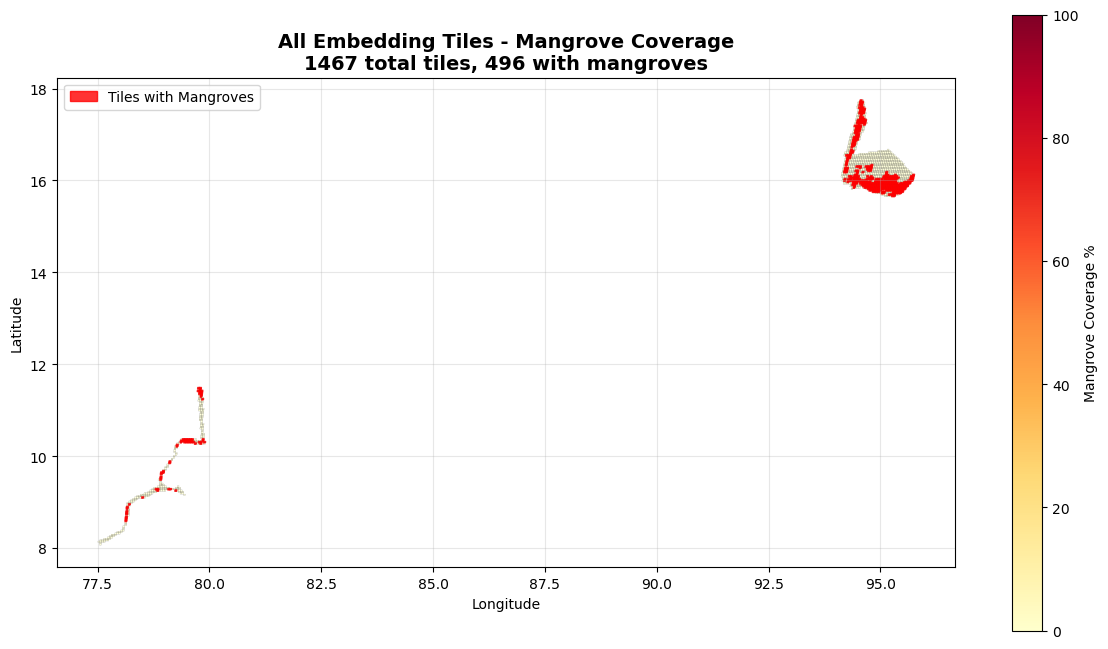

Overview: 496 out of 1467 tiles (33.8%) have mangroves


In [43]:
# Create an overview map of all tiles colored by coverage
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all tiles
gdf.plot(
    column='mangrove_coverage_percent',
    ax=ax,
    cmap='YlOrRd',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.1,
    legend=True,
    legend_kwds={'label': 'Mangrove Coverage %', 'shrink': 0.8}
)

# Highlight tiles with mangroves
mangrove_tiles = gdf[gdf['mangrove_coverage_percent'] > 0]
if len(mangrove_tiles) > 0:
    mangrove_tiles.plot(
        ax=ax,
        facecolor='none',
        edgecolor='red',
        linewidth=1,
        alpha=0.8
    )

ax.set_title(f'All Embedding Tiles - Mangrove Coverage\n{len(gdf)} total tiles, {len(mangrove_tiles)} with mangroves', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)

# Add legend for highlighted tiles
red_patch = mpatches.Patch(color='red', alpha=0.8, label='Tiles with Mangroves')
ax.legend(handles=[red_patch], loc='upper left')

plt.tight_layout()
plt.show()

print(f"Overview: {len(mangrove_tiles)} out of {len(gdf)} tiles ({len(mangrove_tiles)/len(gdf)*100:.1f}%) have mangroves")

## 2. Clustering Analysis

Perform K-means clustering on the embedding vectors and visualize the results.

In [44]:
# Extract embedding vectors
print("Extracting embedding vectors...")
# Handle nested array structure - embeddings are stored as arrays containing arrays
embeddings = np.array([emb[0] if isinstance(emb, np.ndarray) and emb.ndim > 0 and len(emb) > 0 else emb for emb in gdf['embedding']])
print(f"Embedding shape: {embeddings.shape}")
print(f"Embedding vector dimension: {embeddings.shape[1]}")

# Check for NaN values
nan_mask = np.isnan(embeddings).any(axis=1)
print(f"Rows with NaN values: {nan_mask.sum()}")

# Remove rows with NaN values
if nan_mask.sum() > 0:
    print(f"Removing {nan_mask.sum()} rows with NaN values...")
    gdf_clean = gdf[~nan_mask].copy()
    embeddings_clean = embeddings[~nan_mask]
    print(f"Clean dataset: {len(gdf_clean)} tiles, embedding shape: {embeddings_clean.shape}")
else:
    gdf_clean = gdf.copy()
    embeddings_clean = embeddings

# Update gdf to use clean version
gdf = gdf_clean
embeddings = embeddings_clean

# Normalize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
print(f"✓ Embeddings normalized")

Extracting embedding vectors...
Embedding shape: (1467, 1024)
Embedding vector dimension: 1024
Rows with NaN values: 523
Removing 523 rows with NaN values...
Clean dataset: 944 tiles, embedding shape: (944, 1024)
✓ Embeddings normalized


In [45]:
# Perform K-means clustering
n_clusters = 10
print(f"Performing K-means clustering with {n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_scaled)

# Add cluster labels to dataframe
gdf['cluster'] = cluster_labels

print(f"✓ Clustering complete")
print(f"Cluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    cluster_tiles = gdf[gdf['cluster'] == cluster_id]
    mangrove_count = (cluster_tiles['mangrove_coverage_percent'] > 0).sum()
    avg_coverage = cluster_tiles['mangrove_coverage_percent'].mean()
    print(f"  Cluster {cluster_id}: {count} tiles, {mangrove_count} with mangroves, avg coverage: {avg_coverage:.2f}%")

Performing K-means clustering with 10 clusters...
✓ Clustering complete
Cluster distribution:
  Cluster 0: 58 tiles, 15 with mangroves, avg coverage: 25.86%
  Cluster 1: 86 tiles, 20 with mangroves, avg coverage: 23.26%
  Cluster 2: 98 tiles, 12 with mangroves, avg coverage: 12.24%
  Cluster 3: 81 tiles, 39 with mangroves, avg coverage: 48.15%
  Cluster 4: 61 tiles, 10 with mangroves, avg coverage: 16.39%
  Cluster 5: 150 tiles, 14 with mangroves, avg coverage: 9.33%
  Cluster 6: 112 tiles, 46 with mangroves, avg coverage: 41.07%
  Cluster 7: 106 tiles, 26 with mangroves, avg coverage: 24.53%
  Cluster 8: 125 tiles, 85 with mangroves, avg coverage: 68.00%
  Cluster 9: 67 tiles, 0 with mangroves, avg coverage: 0.00%


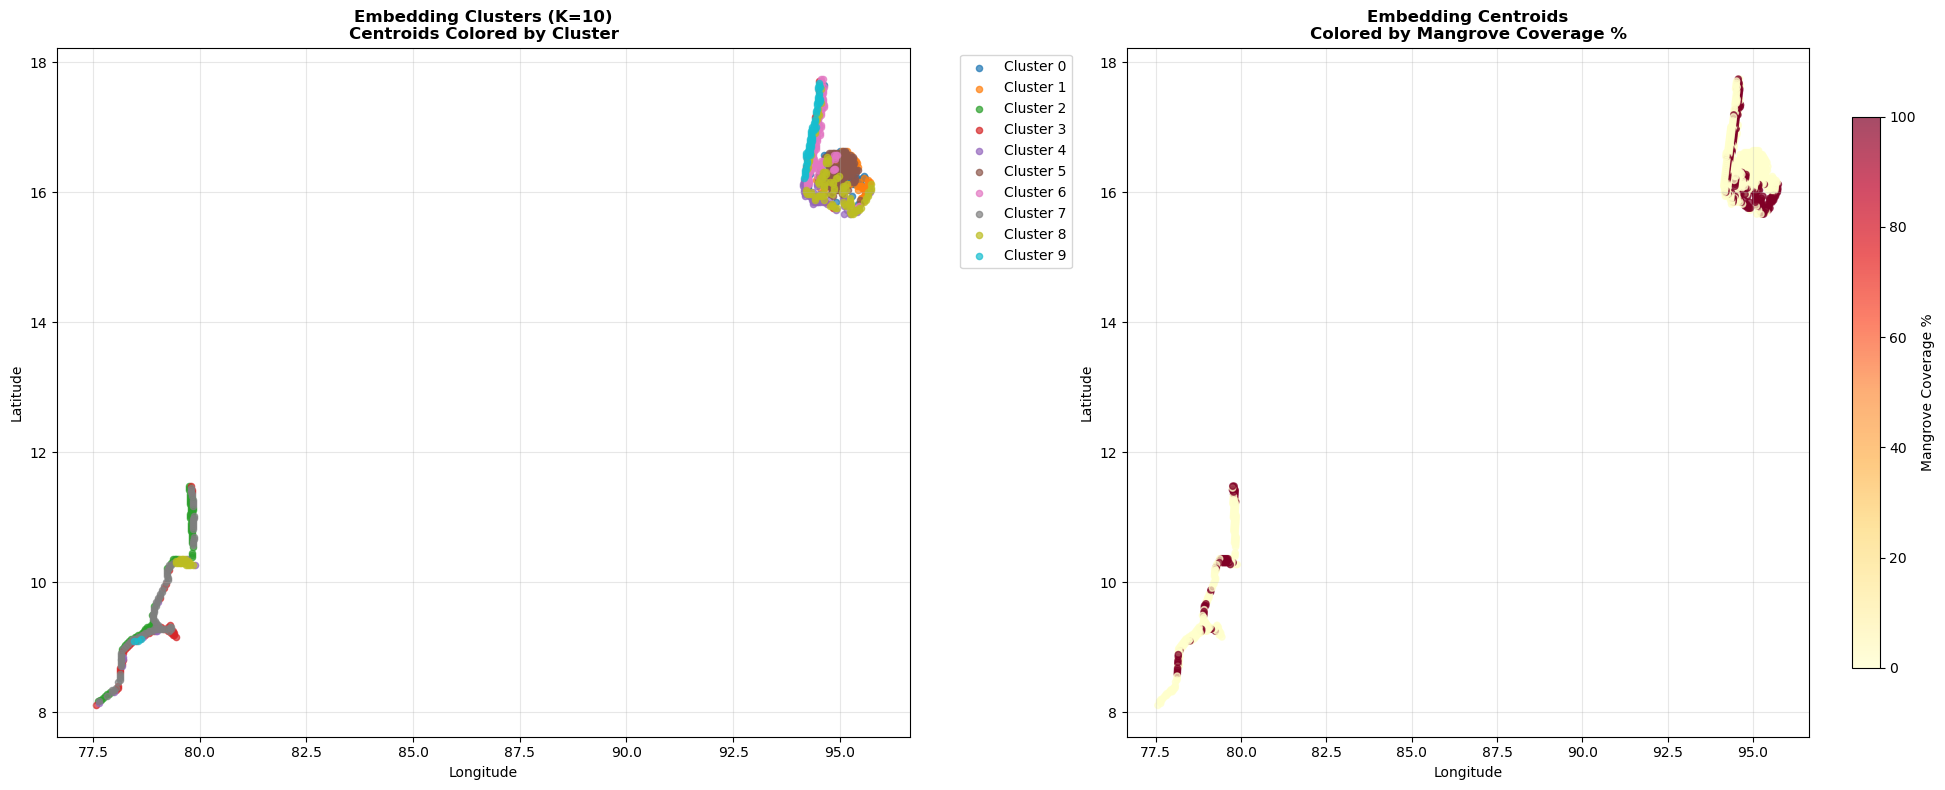

In [46]:
# Visualize clusters spatially
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left: Cluster centroids colored by cluster
# Extract centroids
gdf['centroid_lon'] = gdf.geometry.centroid.x
gdf['centroid_lat'] = gdf.geometry.centroid.y

# Create a colormap for clusters
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

for cluster_id in range(n_clusters):
    cluster_data = gdf[gdf['cluster'] == cluster_id]
    ax1.scatter(
        cluster_data['centroid_lon'], 
        cluster_data['centroid_lat'],
        c=[cluster_colors[cluster_id]], 
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        s=20
    )

ax1.set_title(f'Embedding Clusters (K={n_clusters})\nCentroids Colored by Cluster', fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Right: Centroids colored by mangrove coverage
scatter = ax2.scatter(
    gdf['centroid_lon'], 
    gdf['centroid_lat'],
    c=gdf['mangrove_coverage_percent'],
    cmap='YlOrRd',
    alpha=0.7,
    s=20
)

ax2.set_title('Embedding Centroids\nColored by Mangrove Coverage %', fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2, shrink=0.8)
cbar.set_label('Mangrove Coverage %')

plt.tight_layout()
plt.show()

In [47]:
# Analyze cluster characteristics
cluster_analysis = []

for cluster_id in range(n_clusters):
    cluster_data = gdf[gdf['cluster'] == cluster_id]
    
    analysis = {
        'cluster_id': cluster_id,
        'n_tiles': len(cluster_data),
        'n_mangrove_tiles': (cluster_data['mangrove_coverage_percent'] > 0).sum(),
        'mangrove_percentage': (cluster_data['mangrove_coverage_percent'] > 0).sum() / len(cluster_data) * 100,
        'avg_coverage': cluster_data['mangrove_coverage_percent'].mean(),
        'max_coverage': cluster_data['mangrove_coverage_percent'].max(),
        'geographic_spread_lon': cluster_data['centroid_lon'].std(),
        'geographic_spread_lat': cluster_data['centroid_lat'].std(),
        'center_lon': cluster_data['centroid_lon'].mean(),
        'center_lat': cluster_data['centroid_lat'].mean()
    }
    cluster_analysis.append(analysis)

cluster_df = pd.DataFrame(cluster_analysis)
cluster_df = cluster_df.sort_values('avg_coverage', ascending=False)

print("Cluster Analysis (sorted by average coverage):")
print(cluster_df.round(3))

Cluster Analysis (sorted by average coverage):
   cluster_id  n_tiles  n_mangrove_tiles  mangrove_percentage  avg_coverage  \
8           8      125                85               68.000        68.000   
3           3       81                39               48.148        48.148   
6           6      112                46               41.071        41.071   
0           0       58                15               25.862        25.862   
7           7      106                26               24.528        24.528   
1           1       86                20               23.256        23.256   
4           4       61                10               16.393        16.393   
2           2       98                12               12.245        12.245   
5           5      150                14                9.333         9.333   
9           9       67                 0                0.000         0.000   

   max_coverage  geographic_spread_lon  geographic_spread_lat  center_lon  \
8     

In [48]:
# Export cluster results
output_file = Path("test_scripts/embedding_clusters_analysis.parquet")
gdf[['geometry', 'mangrove_coverage_percent', 'cluster', 'centroid_lon', 'centroid_lat']].to_parquet(output_file)
print(f"✓ Cluster results exported to {output_file}")

# Also export cluster summary
cluster_summary_file = Path("test_scripts/cluster_summary.csv")
cluster_df.to_csv(cluster_summary_file, index=False)
print(f"✓ Cluster summary exported to {cluster_summary_file}")

✓ Cluster results exported to test_scripts/embedding_clusters_analysis.parquet
✓ Cluster summary exported to test_scripts/cluster_summary.csv


## 3. Dimensionality Reduction Analysis

Visualize embeddings in t-SNE and PCA space, colored by mangrove coverage.

In [49]:
# PCA Analysis
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Add PCA coordinates to dataframe
gdf['pca_1'] = embeddings_pca[:, 0]
gdf['pca_2'] = embeddings_pca[:, 1]

print("✓ PCA complete")

Performing PCA...
PCA explained variance ratio: [0.13687197 0.12441972]
Total variance explained: 0.261
✓ PCA complete


In [50]:
# t-SNE Analysis
print("Performing t-SNE (this may take a while...)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# Add t-SNE coordinates to dataframe
gdf['tsne_1'] = embeddings_tsne[:, 0]
gdf['tsne_2'] = embeddings_tsne[:, 1]

print("✓ t-SNE complete")

Performing t-SNE (this may take a while...)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 944 samples in 0.001s...


[t-SNE] Computed neighbors for 944 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 944 / 944
[t-SNE] Mean sigma: 11.116429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.863602
[t-SNE] KL divergence after 1000 iterations: 0.711933
✓ t-SNE complete


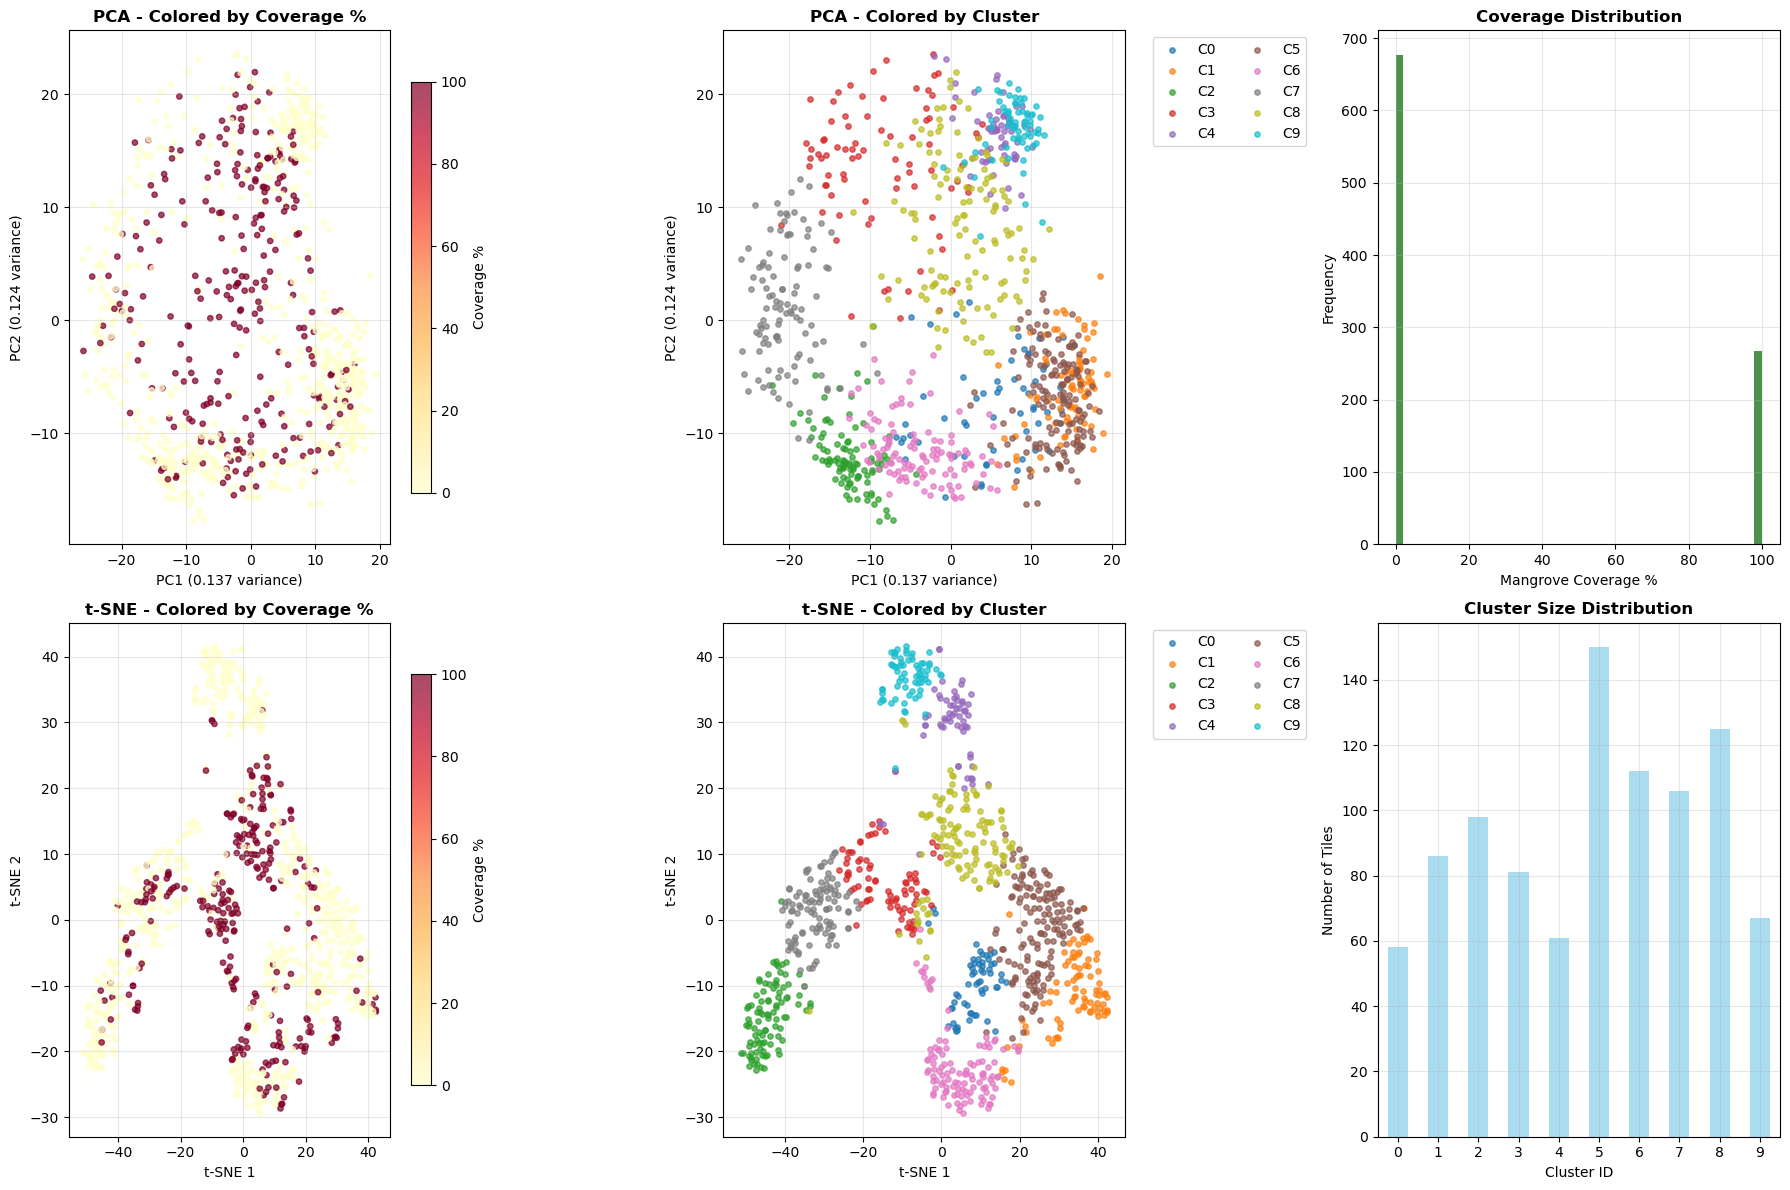

In [51]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PCA plots
# PCA colored by coverage
scatter1 = axes[0, 0].scatter(
    gdf['pca_1'], gdf['pca_2'], 
    c=gdf['mangrove_coverage_percent'], 
    cmap='YlOrRd', 
    alpha=0.7, 
    s=15
)
axes[0, 0].set_title('PCA - Colored by Coverage %', fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0], shrink=0.8)
cbar1.set_label('Coverage %')

# PCA colored by cluster
for cluster_id in range(n_clusters):
    cluster_data = gdf[gdf['cluster'] == cluster_id]
    axes[0, 1].scatter(
        cluster_data['pca_1'], cluster_data['pca_2'],
        c=[cluster_colors[cluster_id]], 
        label=f'C{cluster_id}',
        alpha=0.7,
        s=15
    )
axes[0, 1].set_title('PCA - Colored by Cluster', fontweight='bold')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
axes[0, 1].grid(True, alpha=0.3)

# t-SNE plots
# t-SNE colored by coverage
scatter2 = axes[1, 0].scatter(
    gdf['tsne_1'], gdf['tsne_2'], 
    c=gdf['mangrove_coverage_percent'], 
    cmap='YlOrRd', 
    alpha=0.7, 
    s=15
)
axes[1, 0].set_title('t-SNE - Colored by Coverage %', fontweight='bold')
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
axes[1, 0].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1, 0], shrink=0.8)
cbar2.set_label('Coverage %')

# t-SNE colored by cluster
for cluster_id in range(n_clusters):
    cluster_data = gdf[gdf['cluster'] == cluster_id]
    axes[1, 1].scatter(
        cluster_data['tsne_1'], cluster_data['tsne_2'],
        c=[cluster_colors[cluster_id]], 
        label=f'C{cluster_id}',
        alpha=0.7,
        s=15
    )
axes[1, 1].set_title('t-SNE - Colored by Cluster', fontweight='bold')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
axes[1, 1].grid(True, alpha=0.3)

# Coverage distribution
axes[0, 2].hist(gdf['mangrove_coverage_percent'], bins=50, alpha=0.7, color='darkgreen')
axes[0, 2].set_title('Coverage Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Mangrove Coverage %')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# Cluster size distribution
cluster_counts.plot(kind='bar', ax=axes[1, 2], color='skyblue', alpha=0.7)
axes[1, 2].set_title('Cluster Size Distribution', fontweight='bold')
axes[1, 2].set_xlabel('Cluster ID')
axes[1, 2].set_ylabel('Number of Tiles')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [52]:
# Analysis of embedding space structure
print("Embedding Space Analysis:")
print("=" * 40)

# Correlation between coverage and embedding dimensions
print("\n1. Coverage correlation with PCA components:")
pca_coverage_corr = [
    np.corrcoef(gdf['mangrove_coverage_percent'], gdf['pca_1'])[0, 1],
    np.corrcoef(gdf['mangrove_coverage_percent'], gdf['pca_2'])[0, 1]
]
print(f"   PC1 correlation: {pca_coverage_corr[0]:.4f}")
print(f"   PC2 correlation: {pca_coverage_corr[1]:.4f}")

# Coverage statistics by cluster
print("\n2. Coverage statistics by cluster:")
for cluster_id in range(n_clusters):
    cluster_data = gdf[gdf['cluster'] == cluster_id]
    coverage_stats = cluster_data['mangrove_coverage_percent'].describe()
    print(f"   Cluster {cluster_id}: mean={coverage_stats['mean']:.2f}%, std={coverage_stats['std']:.2f}%, max={coverage_stats['max']:.2f}%")

# Geographic clustering analysis
print("\n3. Geographic clustering:")
for cluster_id in range(n_clusters):
    cluster_data = gdf[gdf['cluster'] == cluster_id]
    lon_std = cluster_data['centroid_lon'].std()
    lat_std = cluster_data['centroid_lat'].std()
    geographic_spread = np.sqrt(lon_std**2 + lat_std**2)
    print(f"   Cluster {cluster_id}: geographic spread = {geographic_spread:.4f} degrees")

Embedding Space Analysis:

1. Coverage correlation with PCA components:
   PC1 correlation: -0.1065
   PC2 correlation: 0.1009

2. Coverage statistics by cluster:
   Cluster 0: mean=25.86%, std=44.17%, max=100.00%
   Cluster 1: mean=23.26%, std=42.49%, max=100.00%
   Cluster 2: mean=12.24%, std=32.95%, max=100.00%
   Cluster 3: mean=48.15%, std=50.28%, max=100.00%
   Cluster 4: mean=16.39%, std=37.33%, max=100.00%
   Cluster 5: mean=9.33%, std=29.19%, max=100.00%
   Cluster 6: mean=41.07%, std=49.42%, max=100.00%
   Cluster 7: mean=24.53%, std=43.23%, max=100.00%
   Cluster 8: mean=68.00%, std=46.84%, max=100.00%
   Cluster 9: mean=0.00%, std=0.00%, max=0.00%

3. Geographic clustering:
   Cluster 0: geographic spread = 0.5640 degrees
   Cluster 1: geographic spread = 0.4036 degrees
   Cluster 2: geographic spread = 1.1974 degrees
   Cluster 3: geographic spread = 8.7431 degrees
   Cluster 4: geographic spread = 7.1157 degrees
   Cluster 5: geographic spread = 0.2822 degrees
   Cluster 

In [53]:
# Export dimensionality reduction results
export_columns = [
    'geometry', 'mangrove_coverage_percent', 'cluster', 
    'centroid_lon', 'centroid_lat',
    'pca_1', 'pca_2', 'tsne_1', 'tsne_2'
]

output_file = Path("test_scripts/embedding_analysis_complete.parquet")
gdf[export_columns].to_parquet(output_file)
print(f"✓ Complete analysis exported to {output_file}")

# Create summary statistics
summary_stats = {
    'total_tiles': int(len(gdf)),
    'tiles_with_mangroves': int((gdf['mangrove_coverage_percent'] > 0).sum()),
    'mean_coverage': float(gdf['mangrove_coverage_percent'].mean()),
    'std_coverage': float(gdf['mangrove_coverage_percent'].std()),
    'max_coverage': float(gdf['mangrove_coverage_percent'].max()),
    'n_clusters': int(n_clusters),
    'pca_variance_explained': float(pca.explained_variance_ratio_.sum()),
    'pca_pc1_coverage_corr': float(pca_coverage_corr[0]),
    'pca_pc2_coverage_corr': float(pca_coverage_corr[1])
}

summary_file = Path("test_scripts/analysis_summary.json")
import json
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✓ Summary statistics exported to {summary_file}")

print("\n" + "="*50)
print("QA ANALYSIS COMPLETE")
print("="*50)
print(f"📊 Analyzed {len(gdf)} embedding tiles")
print(f"🌳 Found {(gdf['mangrove_coverage_percent'] > 0).sum()} tiles with mangroves")
print(f"📈 Mean coverage: {gdf['mangrove_coverage_percent'].mean():.2f}%")
print(f"🎯 Created {n_clusters} clusters")
print(f"📁 Results exported to test_scripts/")

✓ Complete analysis exported to test_scripts/embedding_analysis_complete.parquet
✓ Summary statistics exported to test_scripts/analysis_summary.json

QA ANALYSIS COMPLETE
📊 Analyzed 944 embedding tiles
🌳 Found 267 tiles with mangroves
📈 Mean coverage: 28.28%
🎯 Created 10 clusters
📁 Results exported to test_scripts/


## 4. Predictive Modeling

Train a simple feedforward neural network to predict mangrove coverage from embeddings.

In [54]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("PyTorch version:", torch.__version__)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare data
X = embeddings_scaled  # Already normalized embeddings
y = gdf['mangrove_coverage_percent'].values

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Coverage range: {y.min():.2f}% - {y.max():.2f}%")
print(f"Non-zero coverage samples: {(y > 0).sum()} out of {len(y)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > 0)
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train coverage: {y_train.mean():.2f}%, Test coverage: {y_test.mean():.2f}%")

PyTorch version: 2.7.1+cu126
Using device: cuda
Data shape: X=(944, 1024), y=(944,)
Coverage range: 0.00% - 100.00%
Non-zero coverage samples: 267 out of 944
Train set: (755, 1024), Test set: (189, 1024)
Train coverage: 28.34%, Test coverage: 28.04%


In [61]:
# Define simple feedforward network
class MangroveCoveragePredictor(nn.Module):
    def __init__(self, input_dim):
        super(MangroveCoveragePredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return torch.clamp(self.network(x), min=0, max=100)  # Clamp output to [0, 100]

# Initialize model
input_dim = X_train.shape[1]
model = MangroveCoveragePredictor(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print("Model architecture:")
print(model)

Model initialized with 697345 parameters
Model architecture:
MangroveCoveragePredictor(
  (network): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [62]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

print("Starting training...")
model.train()

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_batches += 1
    
    # Calculate average training loss
    avg_train_loss = epoch_train_loss / num_batches
    train_losses.append(avg_train_loss)
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
    model.train()
    
    # Update learning rate
    scheduler.step(val_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

print("✓ Training complete")

Starting training...
Epoch [20/100], Train Loss: 2545.1363, Val Loss: 2507.2063
Epoch [40/100], Train Loss: 1181.8468, Val Loss: 1302.5480
Epoch [60/100], Train Loss: 949.4404, Val Loss: 1205.7152
Epoch [80/100], Train Loss: 820.5366, Val Loss: 1169.5007
Epoch [100/100], Train Loss: 729.2241, Val Loss: 1158.1934
✓ Training complete


In [63]:
# Make predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor).cpu().numpy().flatten()
    test_pred = model(X_test_tensor).cpu().numpy().flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("Model Performance:")
print("=" * 40)
print(f"Training Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Additional analysis for non-zero predictions
train_nonzero_mask = y_train > 0
test_nonzero_mask = y_test > 0

if train_nonzero_mask.sum() > 0:
    train_nonzero_r2 = r2_score(y_train[train_nonzero_mask], train_pred[train_nonzero_mask])
    print(f"\nNon-zero samples only:")
    print(f"  Train R² (mangrove tiles): {train_nonzero_r2:.4f}")

if test_nonzero_mask.sum() > 0:
    test_nonzero_r2 = r2_score(y_test[test_nonzero_mask], test_pred[test_nonzero_mask])
    print(f"  Test R² (mangrove tiles):  {test_nonzero_r2:.4f}")

Model Performance:
Training Set:
  RMSE: 26.8547
  MAE:  18.1581
  R²:   0.6449

Test Set:
  RMSE: 34.0322
  MAE:  23.9691
  R²:   0.4260

Non-zero samples only:
  Train R² (mangrove tiles): 0.0000
  Test R² (mangrove tiles):  0.0000


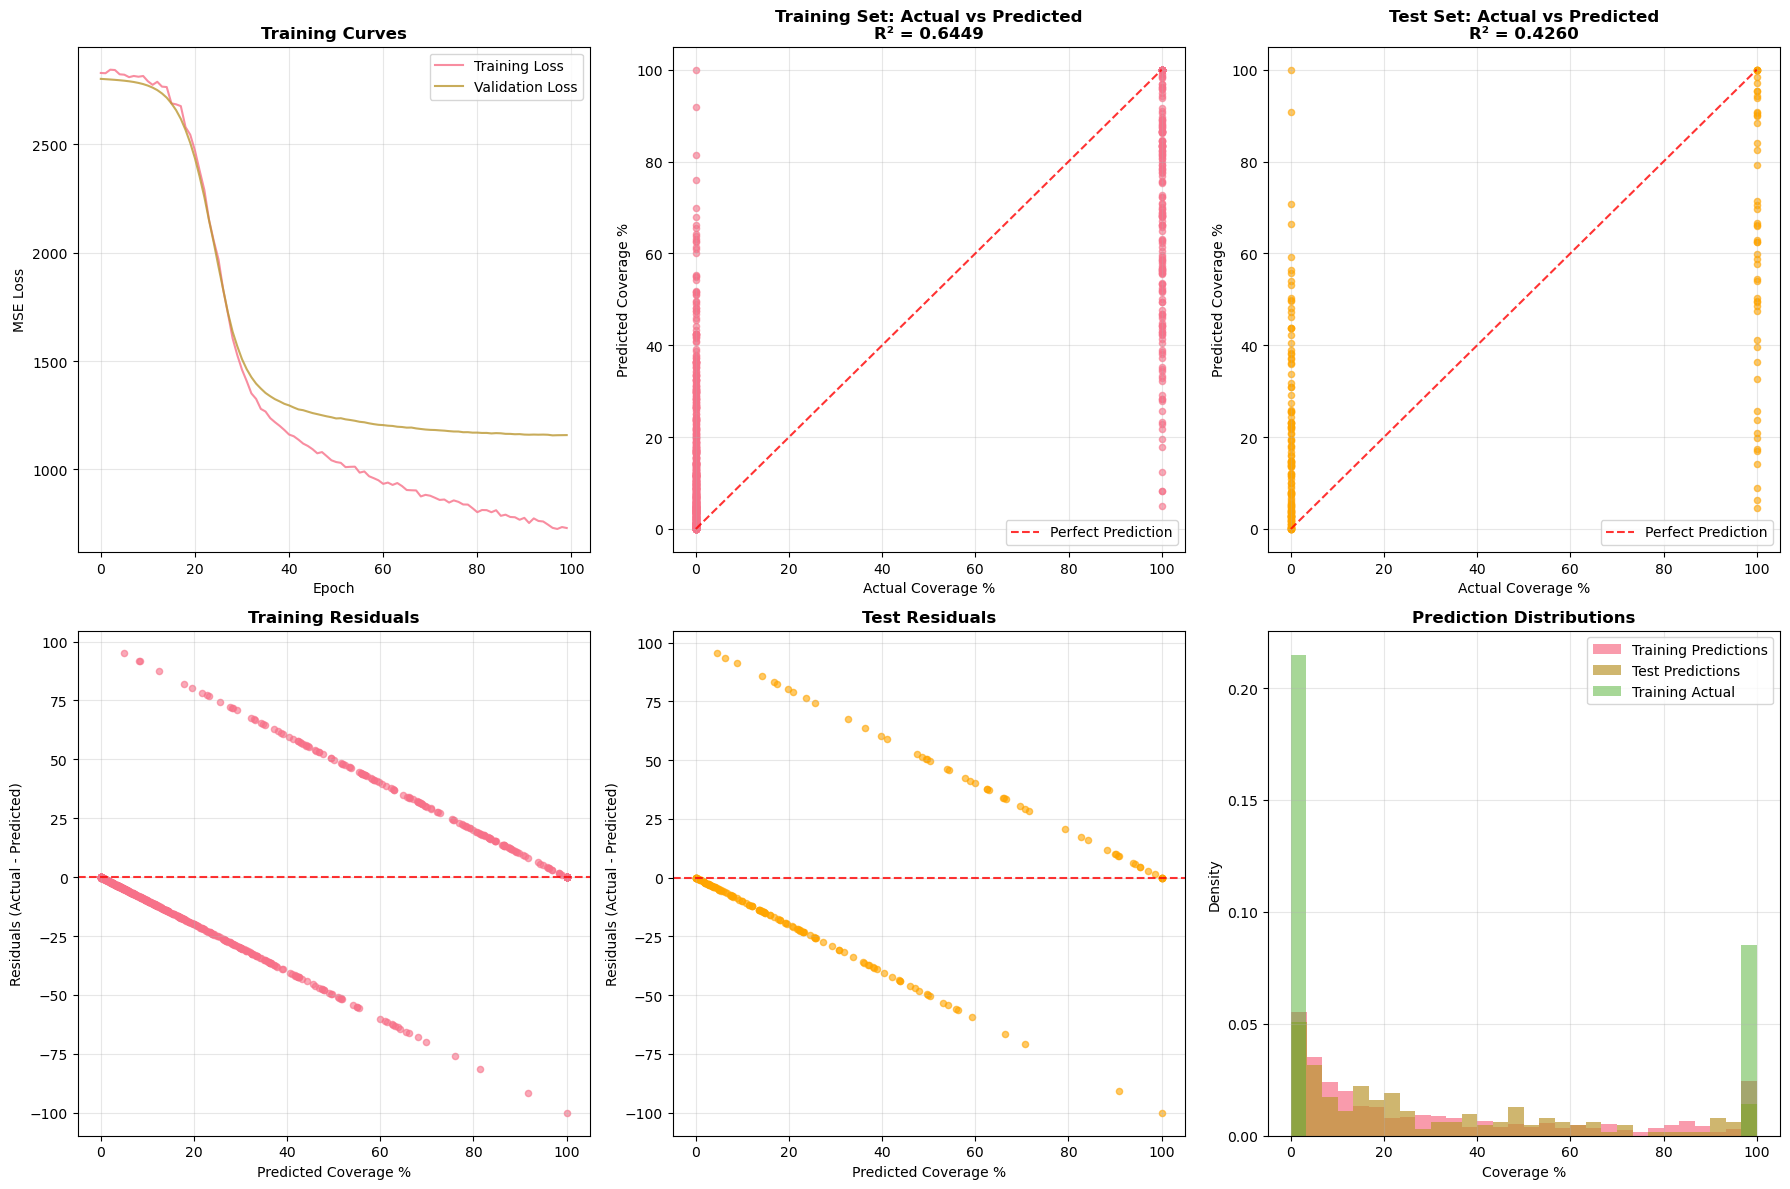


Prediction Summary:
Training predictions range: 0.04% - 100.00%
Test predictions range: 0.04% - 100.00%
Training actual range: 0.00% - 100.00%
Test actual range: 0.00% - 100.00%

Accuracy by coverage range (Test Set):
  0%-1%: 136 samples, MAE=18.654, R²=0.000


In [64]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training curve
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
axes[0, 0].set_title('Training Curves', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Training)
axes[0, 1].scatter(y_train, train_pred, alpha=0.6, s=20)
axes[0, 1].plot([0, 100], [0, 100], 'r--', alpha=0.8, label='Perfect Prediction')
axes[0, 1].set_title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.4f}', fontweight='bold')
axes[0, 1].set_xlabel('Actual Coverage %')
axes[0, 1].set_ylabel('Predicted Coverage %')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Actual vs Predicted (Test)
axes[0, 2].scatter(y_test, test_pred, alpha=0.6, s=20, color='orange')
axes[0, 2].plot([0, 100], [0, 100], 'r--', alpha=0.8, label='Perfect Prediction')
axes[0, 2].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2:.4f}', fontweight='bold')
axes[0, 2].set_xlabel('Actual Coverage %')
axes[0, 2].set_ylabel('Predicted Coverage %')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals (Training)
train_residuals = y_train - train_pred
axes[1, 0].scatter(train_pred, train_residuals, alpha=0.6, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 0].set_title('Training Residuals', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Coverage %')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Residuals (Test)
test_residuals = y_test - test_pred
axes[1, 1].scatter(test_pred, test_residuals, alpha=0.6, s=20, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_title('Test Residuals', fontweight='bold')
axes[1, 1].set_xlabel('Predicted Coverage %')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction histogram
axes[1, 2].hist(train_pred, bins=30, alpha=0.7, label='Training Predictions', density=True)
axes[1, 2].hist(test_pred, bins=30, alpha=0.7, label='Test Predictions', density=True)
axes[1, 2].hist(y_train, bins=30, alpha=0.5, label='Training Actual', density=True)
axes[1, 2].set_title('Prediction Distributions', fontweight='bold')
axes[1, 2].set_xlabel('Coverage %')
axes[1, 2].set_ylabel('Density')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPrediction Summary:")
print("=" * 40)
print(f"Training predictions range: {train_pred.min():.2f}% - {train_pred.max():.2f}%")
print(f"Test predictions range: {test_pred.min():.2f}% - {test_pred.max():.2f}%")
print(f"Training actual range: {y_train.min():.2f}% - {y_train.max():.2f}%")
print(f"Test actual range: {y_test.min():.2f}% - {y_test.max():.2f}%")

# Analyze prediction accuracy for different coverage ranges
coverage_ranges = [(0, 1), (1, 10), (10, 50), (50, 100)]
print(f"\nAccuracy by coverage range (Test Set):")
for low, high in coverage_ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test[mask], test_pred[mask])
        range_r2 = r2_score(y_test[mask], test_pred[mask]) if mask.sum() > 1 else np.nan
        print(f"  {low}%-{high}%: {mask.sum()} samples, MAE={range_mae:.3f}, R²={range_r2:.3f}")

In [59]:
# Export model results
model_results = {
    'train_actual': y_train.tolist(),
    'train_predicted': train_pred.tolist(),
    'test_actual': y_test.tolist(),
    'test_predicted': test_pred.tolist(),
    'train_metrics': {
        'rmse': float(train_rmse),
        'mae': float(train_mae),
        'r2': float(train_r2)
    },
    'test_metrics': {
        'rmse': float(test_rmse),
        'mae': float(test_mae),
        'r2': float(test_r2)
    },
    'model_params': {
        'input_dim': input_dim,
        'num_epochs': num_epochs,
        'batch_size': 32,
        'learning_rate': 0.001
    }
}

# Save model results
results_file = Path("test_scripts/pytorch_model_results.json")
with open(results_file, 'w') as f:
    json.dump(model_results, f, indent=2)
print(f"✓ Model results exported to {results_file}")

# Save the trained model
model_file = Path("test_scripts/mangrove_coverage_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'model_class': 'MangroveCoveragePredictor'
    },
    'train_metrics': model_results['train_metrics'],
    'test_metrics': model_results['test_metrics']
}, model_file)
print(f"✓ Trained model saved to {model_file}")

print("\n" + "="*50)
print("PREDICTIVE MODELING COMPLETE")
print("="*50)
print(f"🧠 Trained feedforward neural network")
print(f"📊 Test R²: {test_r2:.4f}")
print(f"📈 Test RMSE: {test_rmse:.4f}%")
print(f"💾 Model and results saved to test_scripts/")

✓ Model results exported to test_scripts/pytorch_model_results.json
✓ Trained model saved to test_scripts/mangrove_coverage_model.pth

PREDICTIVE MODELING COMPLETE
🧠 Trained feedforward neural network
📊 Test R²: -0.3897
📈 Test RMSE: 52.9550%
💾 Model and results saved to test_scripts/
